In [ ]:
# ruff: noqa
import polars as pl
import endolab as el
from pathlib import Path
import prepare

from llm_workflow import Experiment
from llm_classifier import LLMClassifier, file_logger
from prepare import show_exp
# settings

list_indication = [
    # "遺伝性ポリポーシス",
    # "遺伝性非ポリポーシス",
    "大腸癌術前検査",
    "内視鏡切除",
    "内視鏡治療前精査",
    "既知病変の検査",
    "有症状精査(下血/血便)",
    "有症状精査(下血/血便以外)",
    "他検査で異常(画像検査)",
    "他検査で異常(血液検査)",
    "原発不明がん精査",
    "便潜血精査",
    "大腸癌化療・放射線治療後評価",
    "大腸癌術後サーベイランス",
    "炎症性腸疾患サーベイランス",
    "内視鏡治療後サーベイランス",
    "無症状スクリーニング",
    "その他不明",
]

path_prompt = Path("data/prompt_v5.txt")
path_training = Path("data/indication_training_v6.csv")
path_validate = Path("data/validate_500_v2.csv")

id_column = "id_proc"
target_column = "indication"

# loading data

df = prepare.prepare_data()
df_src = df.select( "id_proc",
"mo_study_purpose",
                "m_special_instruct",
                "hx_surgery",
                "hx_er",
                "hx_crt",
                "hx_ibd",
                "e_comment",)

label_training = (
    pl.read_csv(path_training)
    .select("id_proc", "indication")
    .filter(~pl.col("indication").str.contains("遺伝性"))
    .filter(pl.col("id_proc").is_in(df["id_proc"]))
    # .head(100)
)
df_training = df_src.filter(pl.col("id_proc").is_in(label_training["id_proc"]))
experiment_training = Experiment.load(
    base_dir=Path("exp_training"),
    truth=label_training,
    id_column=id_column,
    target_column=target_column,
    categories=list_indication,
)

label_validate = pl.read_csv(path_validate).select("id_proc", "indication")
df_validate = df_src.filter(pl.col("id_proc").is_in(label_validate["id_proc"]))
experiment_validate = Experiment.load(
    base_dir=Path("exp_validate"),
    truth=label_validate,
    id_column=id_column,
    target_column=target_column,
    categories=list_indication,
)


classifier = LLMClassifier(
    prompt=path_prompt.read_text(),
    categories=list_indication,
    id_column="id_proc",
    target_column="indication",
    multiple_choice_prompt=True,
    #api_base="http://127.0.0.1:11434/v1",
    api_base=f"http://{prepare.get_getway_ipaddress()}:11434/v1",
    model="gpt-oss:20b",
)


print("number of categories", len(list_indication))
print("number of dataframe", len(df))
print("number of training", len(label_training))
print("number of validate", len(label_validate))



In [ ]:
# training setに対して推論を実行する
run = experiment_training.run(
    name="training",
    classifier=classifier,
    df=df_training,
    batch_size=10,
)


shape: (1, 2)
┌──────────────────┬────────────────────────────┐
│ run_id           ┆ timestamp                  │
│ ---              ┆ ---                        │
│ str              ┆ datetime[μs]               │
╞══════════════════╪════════════════════════════╡
│ run_training_001 ┆ 2026-01-28 20:57:52.035909 │
└──────────────────┴────────────────────────────┘


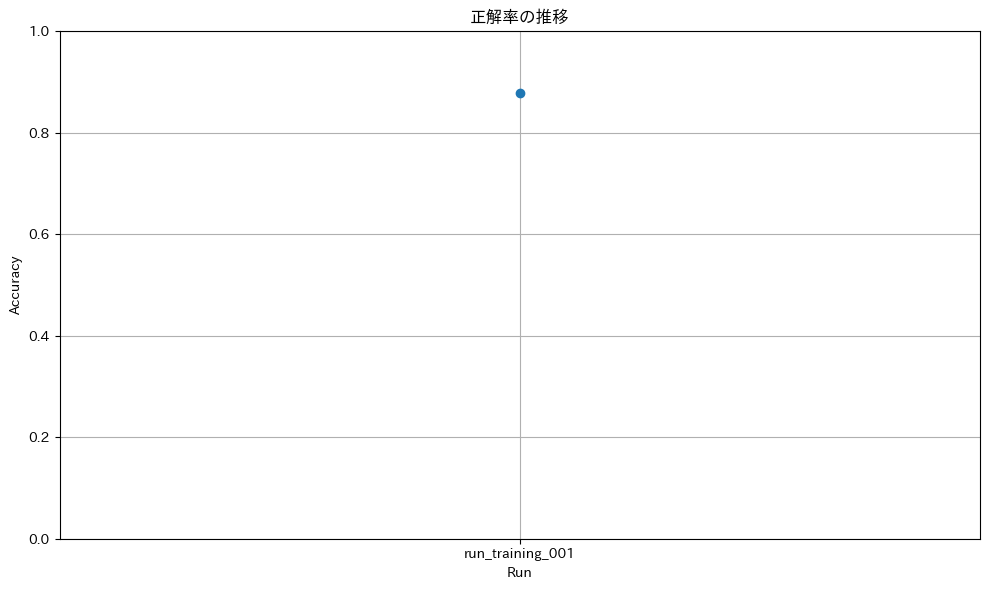


最良のrun: run_training_001 (accuracy=87.8%)
Run run_validate_002 が完了しました
正解率: 87.8% (381/434)


class,precision,recall,f1-score,support
str,f64,f64,f64,f64
"""大腸癌術前検査""",0.906977,1.0,0.95122,39.0
"""内視鏡切除""",0.909091,0.9375,0.923077,64.0
"""内視鏡治療前精査""",0.875,0.736842,0.8,19.0
"""既知病変の検査""",0.52,0.764706,0.619048,17.0
"""有症状精査(下血/血便)""",0.888889,0.941176,0.914286,17.0
"""有症状精査(下血/血便以外)""",0.916667,0.785714,0.846154,14.0
"""他検査で異常(画像検査)""",0.875,1.0,0.933333,7.0
"""他検査で異常(血液検査)""",1.0,0.666667,0.8,6.0
"""原発不明がん精査""",1.0,1.0,1.0,4.0


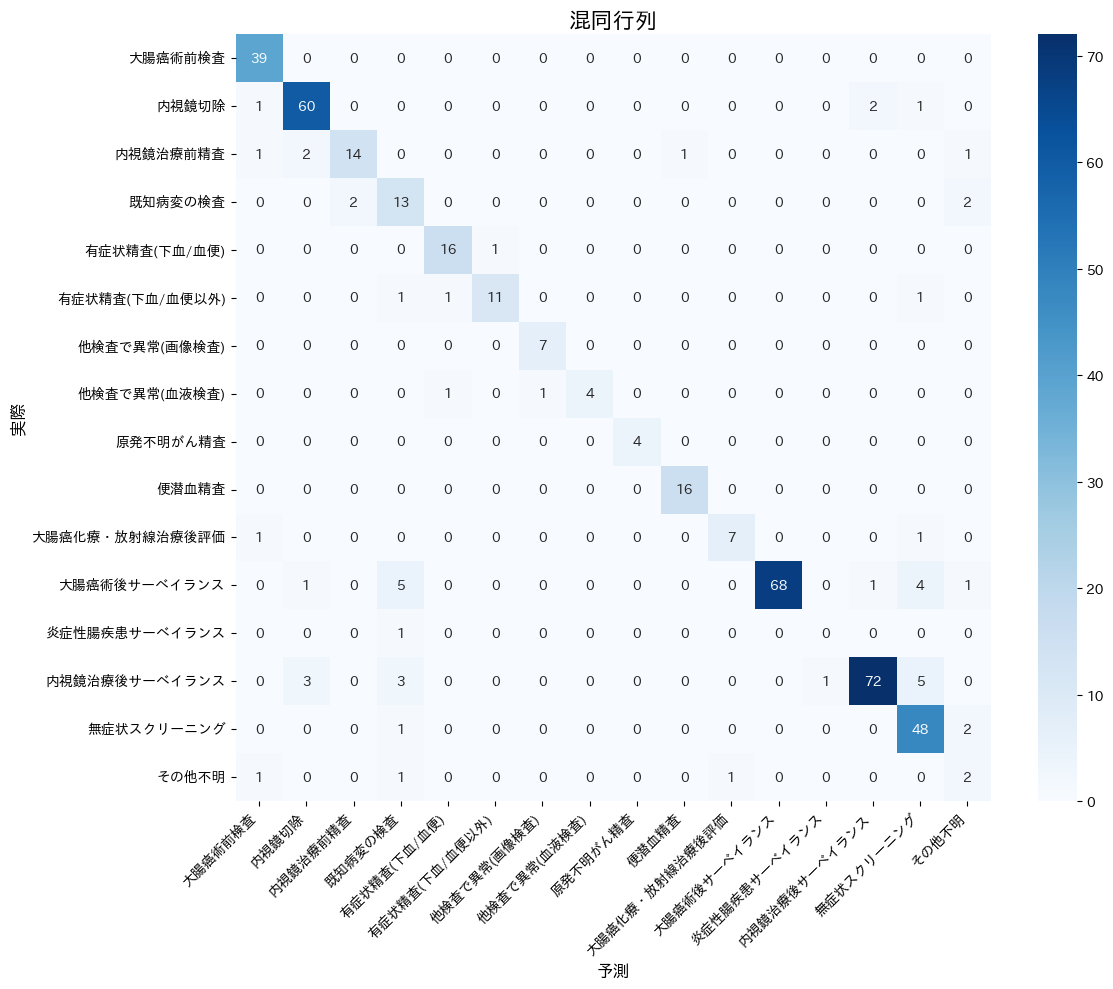


不正解サンプル数: 53
→ errors.xlsxを確認してプロンプトを改良してください


In [8]:
# training setの推論結果を確認する
show_exp(experiment_training)

In [ ]:
# validation setに対して推論を実行する

run = experiment_validate.run(
    name="validate",
    classifier=classifier,
    df=df_validate,
    batch_size=10,
)
show_exp(experiment_validate)

shape: (1, 2)
┌──────────────────┬────────────────────────────┐
│ run_id           ┆ timestamp                  │
│ ---              ┆ ---                        │
│ str              ┆ datetime[μs]               │
╞══════════════════╪════════════════════════════╡
│ run_validate_002 ┆ 2026-01-29 09:17:02.805628 │
└──────────────────┴────────────────────────────┘


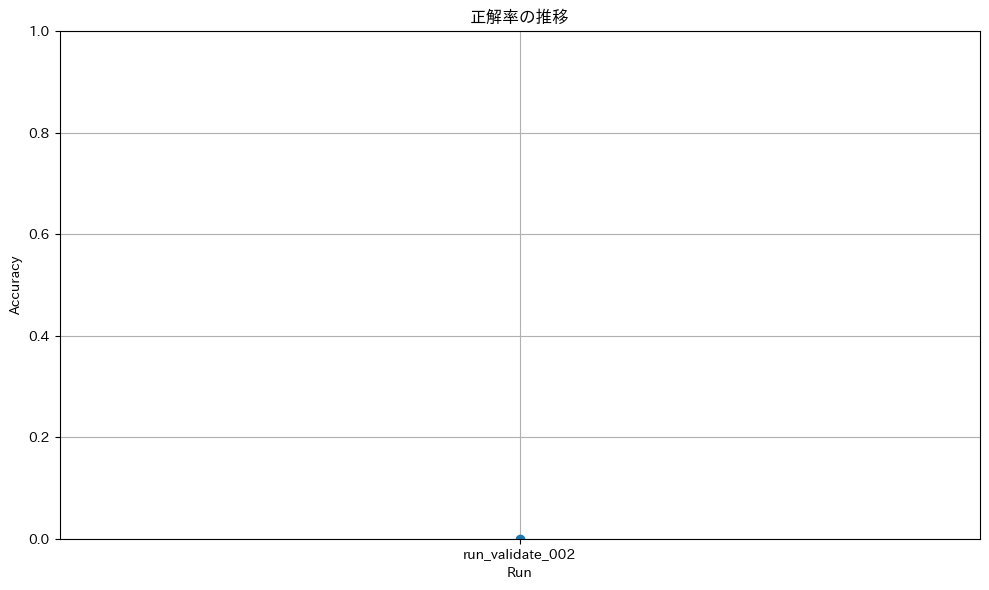

ValueError: No valid samples for evaluation

In [9]:
# validation setの推論結果を確認する
 
show_exp(experiment_validate)


In [ ]:
# # 全データに対して推論

# with file_logger(Path('cache/log.txt')) as logger:
#     result = classifier.classify_with_cache(df, Path('cache'), groupby='ym', batch_size=10, logger=logger)